# **Import Library**

In [ ]:
!pip install tensorflow numpy matplotlib

In [ ]:
!pip install opencv-python

In [ ]:
!pip install albumentations

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import zipfile
import os
import gdown
import albumentations as A
from google.colab import drive
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict
from tensorflow.keras import layers, models
from tqdm import tqdm
from PIL import Image

# **Data Loading**

In [ ]:
# Unduh dan ekstrak dataset
file_id = '1TY3bze_4eAdOPH5VQyAQ1Iag-GJr9qjD'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

output = 'batik_dataset_stabil.zip'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1TY3bze_4eAdOPH5VQyAQ1Iag-GJr9qjD
From (redirected): https://drive.google.com/uc?export=download&id=1TY3bze_4eAdOPH5VQyAQ1Iag-GJr9qjD&confirm=t&uuid=bfbd05ae-abf0-45a3-b11a-560838290e6c
To: /content/batik_dataset_stabil.zip
100%|██████████| 1.07G/1.07G [00:18<00:00, 59.6MB/s]


'batik_dataset_stabil.zip'

In [ ]:
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
# Cek isi folder setelah ekstraksi
os.listdir('/content/dataset')

['Arsitektur', 'Budaya', 'Flora', 'Fauna']

In [ ]:
# Path dataset
dataset_path = '/content/dataset'
themes = ['Arsitektur', 'Budaya', 'Fauna', 'Flora']
theme_to_label = {theme: idx for idx, theme in enumerate(themes)}

In [ ]:
# Output folder
output_dir = '/content/augmented_images'
os.makedirs(output_dir, exist_ok=True)

# **Augmentasi Data Gambar**

In [ ]:
# Augmentasi
augment = A.Compose([
    A.Rotate(limit=20, p=0.3),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.2),
    A.MultiplicativeNoise(p=0.2),
    A.Blur(blur_limit=(3, 7), p=0.2),
    A.MedianBlur(blur_limit=3, p=0.2),
])

In [ ]:
# Label list untuk simpan CSV
label_records = []

# Ambil dan augment gambar per tema
sampled_originals = []  # untuk visualisasi nanti
sampled_augmented = []

counter = 0
for theme in themes:
    theme_path = os.path.join(dataset_path, theme)
    files = [f for f in os.listdir(theme_path) if f.endswith(('.jpg', '.png'))]

    for file in tqdm(files, desc=f'Augmenting {theme}'):
        img_path = os.path.join(theme_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_CUBIC)
        label = theme_to_label[theme]

        # Simpan salah satu original untuk visualisasi
        if len(sampled_originals) < 5:
            sampled_originals.append(img)

        for i in range(15):
            augmented = augment(image=img)['image']
            img_pil = Image.fromarray(augmented)

            filename = f"{theme}_{file[:-4]}_aug{i}.png"
            filepath = os.path.join(output_dir, filename)
            img_pil.save(filepath)

            # Catat label untuk file
            label_records.append((filename, label))

            # Simpan beberapa sampel untuk ditampilkan
            if len(sampled_augmented) < 5:
                sampled_augmented.append(augmented)

            counter += 1

Augmenting Flora: 100%|██████████| 133/133 [07:07<00:00,  3.21s/it]


In [ ]:
# Simpan label sebagai CSV
df_labels = pd.DataFrame(label_records, columns=['filename', 'label'])
df_labels.to_csv(os.path.join(output_dir, 'labels.csv'), index=False)

In [ ]:
# Verifikasi
print("\n--- Verifikasi Data ---")
print(f"Jumlah gambar disimpan: {counter}")
print(f"Jumlah label: {len(label_records)}")
print(f"Contoh label:\n{df_labels.head()}")


--- Verifikasi Data ---
Jumlah gambar disimpan: 7860
Jumlah label: 7860
Contoh label:
                      filename  label
0  Arsitektur_1100019_aug0.png      0
1  Arsitektur_1100019_aug1.png      0
2  Arsitektur_1100019_aug2.png      0
3  Arsitektur_1100019_aug3.png      0
4  Arsitektur_1100019_aug4.png      0


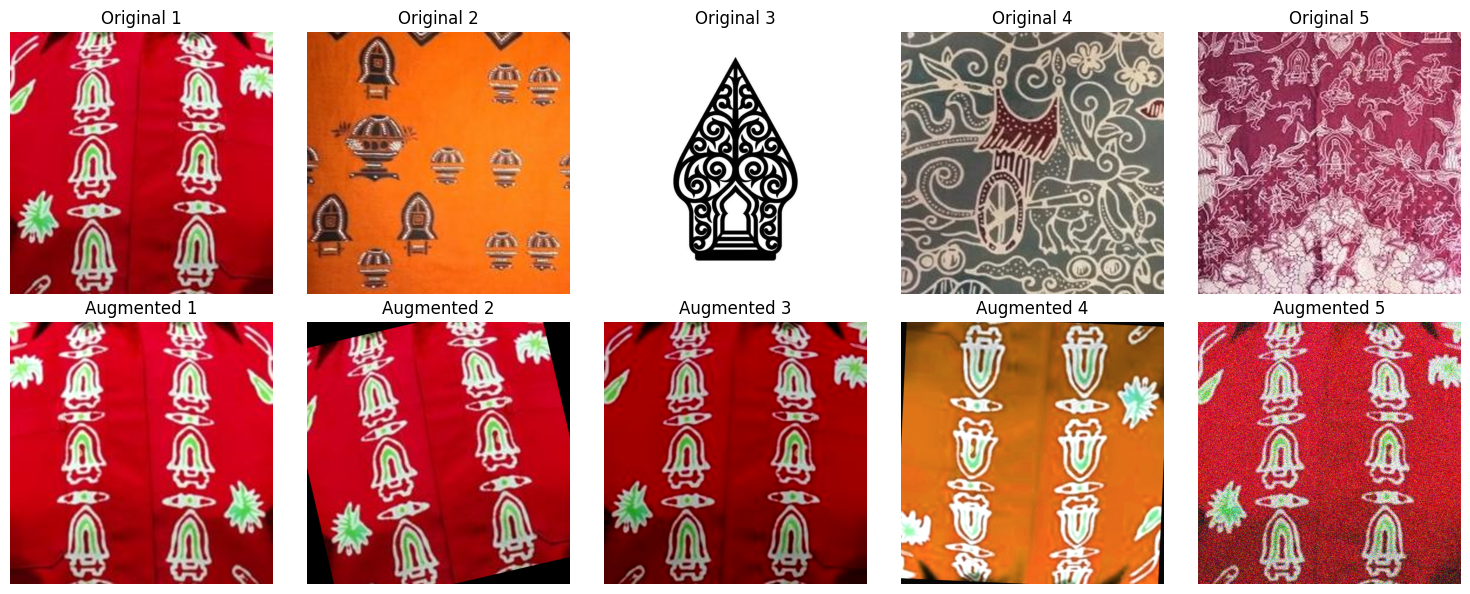

In [ ]:
# Visualisasi 5 sampel original dan augmented
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(sampled_originals[i])
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(sampled_augmented[i])
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(df_labels['label'].value_counts().sort_index())

label
0    1860
1    2025
2    1980
3    1995
Name: count, dtype: int64


# **Split Dataset dan Labeling**

In [ ]:
# Set the path to the output directory where the CSV was saved
output_dir = '/content/augmented_images'

# Baca label CSV dari path yang benar
df = pd.read_csv(os.path.join(output_dir, 'labels.csv'))

# Mapping label ke nama kelas jika perlu (optional)
label_map = {
    0: 'Arsitektur',
    1: 'Budaya',
    2: 'Fauna',
    3: 'Flora'
}
df['class'] = df['label'].map(label_map)

# Buat folder split dataset
base_split_dir = 'batik_split_dataset'
for split in ['train', 'val', 'test']:
    for label in label_map.values():
        os.makedirs(os.path.join(base_split_dir, split, label), exist_ok=True)

# Split per kelas
for label in df['class'].unique():
    class_df = df[df['class'] == label]
    # Adjusted split percentages slightly for train/val/test proportions like 80/10/10 or 70/20/10
    # Using 80/10/10: test_size=0.10, train_val_test_size=0.1111 (0.1 / 0.9)
    # Using 70/20/10: test_size=0.10, train_val_test_size=0.2222 (0.2 / 0.9) which was already used. Let's keep it consistent.
    train_val, test = train_test_split(class_df, test_size=0.10, random_state=42)
    train, val = train_test_split(train_val, test_size=0.1111, random_state=42) # 0.2222 dari 90% = ~20%

    for subset, name in zip([train, val, test], ['train', 'val', 'test']):
        for _, row in subset.iterrows():
            # Ensure the source path is correct, joining with the output_dir
            src = os.path.join(output_dir, row['filename'])
            dst = os.path.join(base_split_dir, name, row['class'], row['filename'])
            # Check if the source file exists before attempting to copy
            if os.path.exists(src):
                shutil.copy2(src, dst)
            else:
                print(f"Warning: Source file not found: {src}")

In [ ]:
# Augmentasi saat training
train_datagen = ImageDataGenerator(rescale=1./255)

# Validasi dan test tidak perlu augmentasi
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Directory
train_dir = os.path.join(base_split_dir, 'train')
val_dir = os.path.join(base_split_dir, 'val')
test_dir = os.path.join(base_split_dir, 'test')

# Load dataset
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'  # Karena label berupa integer
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 6286 images belonging to 4 classes.
Found 787 images belonging to 4 classes.
Found 787 images belonging to 4 classes.


# **Membangun Model**

In [ ]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze layer awal

# Buat model akhir
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4 kelas batik
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mobilenetv2_batik.h5", save_best_only=True)
early_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Training
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, early_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5294 - loss: 1.1163

197/197 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.5297 - loss: 1.1154 - val_accuracy: 0.6963 - val_loss: 0.7059
Epoch 2/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7110 - loss: 0.6767

197/197 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.7110 - loss: 0.6767 - val_accuracy: 0.7179 - val_loss: 0.6462
Epoch 3/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7506 - loss: 0.5913

197/197 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.7507 - loss: 0.5912 - val_accuracy: 0.7421 - val_loss: 0.5639
Epoch 4/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7609 - loss: 0.5320

197/197 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - accuracy: 0.7609 - loss: 0.5320 - val_accuracy: 0.7459 - val_loss: 0.5423
Epoch 5/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.7940 - loss: 0.4686 - val_accuracy: 0.7255 - val_loss: 0.5614
Epoch 6/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.7928 - loss: 0.4605 - val_accuracy: 0.7510 - val_loss: 0.5590
Epoch 7/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.8232 - loss: 0.4198 - val_accuracy: 0.7433 - val_loss: 0.5589
Epoch 8/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 475s 2s/step - accuracy: 0.8288 - loss: 0.3797 - val_accuracy: 0.7382 - val_loss: 0.5877
Epoch 9/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.8374 - loss: 0.3682 - val_accuracy: 0.7510 - val_loss: 0.5492
Epoch 10/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.8427 - loss: 0.3526 - val_accuracy: 0.7421 - val_loss: 0.5517
Epoch 11/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8567 - loss: 0.3344

197/197 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - accuracy: 0.8567 - loss: 0.3345 - val_accuracy: 0.7535 - val_loss: 0.5390
Epoch 12/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 510s 3s/step - accuracy: 0.8675 - loss: 0.3117 - val_accuracy: 0.7573 - val_loss: 0.5478
Epoch 13/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8625 - loss: 0.3114

197/197 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.8625 - loss: 0.3114 - val_accuracy: 0.7535 - val_loss: 0.5327
Epoch 14/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.8690 - loss: 0.2974 - val_accuracy: 0.7484 - val_loss: 0.5713
Epoch 15/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.8759 - loss: 0.2906 - val_accuracy: 0.7522 - val_loss: 0.5794
Epoch 16/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.8715 - loss: 0.2923 - val_accuracy: 0.7522 - val_loss: 0.5676
Epoch 17/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.8776 - loss: 0.2760 - val_accuracy: 0.7408 - val_loss: 0.5730
Epoch 18/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.8870 - loss: 0.2651 - val_accuracy: 0.7497 - val_loss: 0.6235
Epoch 19/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.8869 - loss: 0.2588 - val_accuracy: 0.7510 - val_loss: 0.5876
Epoch 20/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.8917 - loss: 0.2519 - val_accuracy

In [ ]:
learning_rate = 0.0001

## **Fine Tune**

In [ ]:
# unfreeze top layers
base_model.trainable = True
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

history_fine_tune = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, early_cb]
)

Epoch 1/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.8010 - loss: 0.5411 - val_accuracy: 0.7459 - val_loss: 0.5344
Epoch 2/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 537s 3s/step - accuracy: 0.8739 - loss: 0.2979 - val_accuracy: 0.7484 - val_loss: 0.5515
Epoch 3/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.8824 - loss: 0.2792 - val_accuracy: 0.7459 - val_loss: 0.5369
Epoch 4/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.8884 - loss: 0.2585 - val_accuracy: 0.7713 - val_loss: 0.5348
Epoch 5/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.9014 - loss: 0.2388 - val_accuracy: 0.7637 - val_loss: 0.5657
Epoch 6/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.9036 - loss: 0.2257 - val_accuracy: 0.7586 - val_loss: 0.5485
Epoch 7/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.9094 - loss: 0.2137 - val_accuracy: 0.7738 - val_loss: 0.5746
Epoch 8/25
197/197 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.9164 - loss: 0.2084 - val_accu

In [ ]:
validation_loss, validation_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {validation_loss:.3f}, Validation Accuracy: {validation_accuracy:.2%}")

test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2%}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7563 - loss: 0.5154
Validation Loss: 0.534, Validation Accuracy: 74.59%
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8117 - loss: 0.4109
Test Loss: 0.564, Test Accuracy: 74.33%


## **Prediksi Hasil**

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step


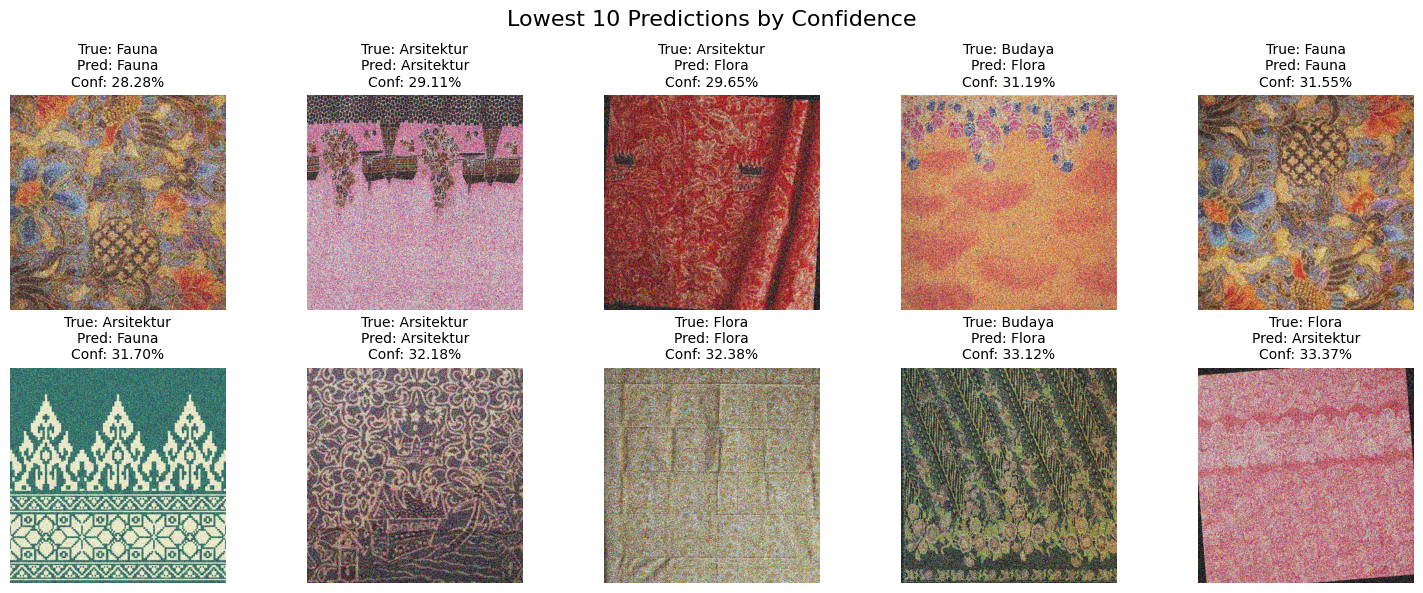

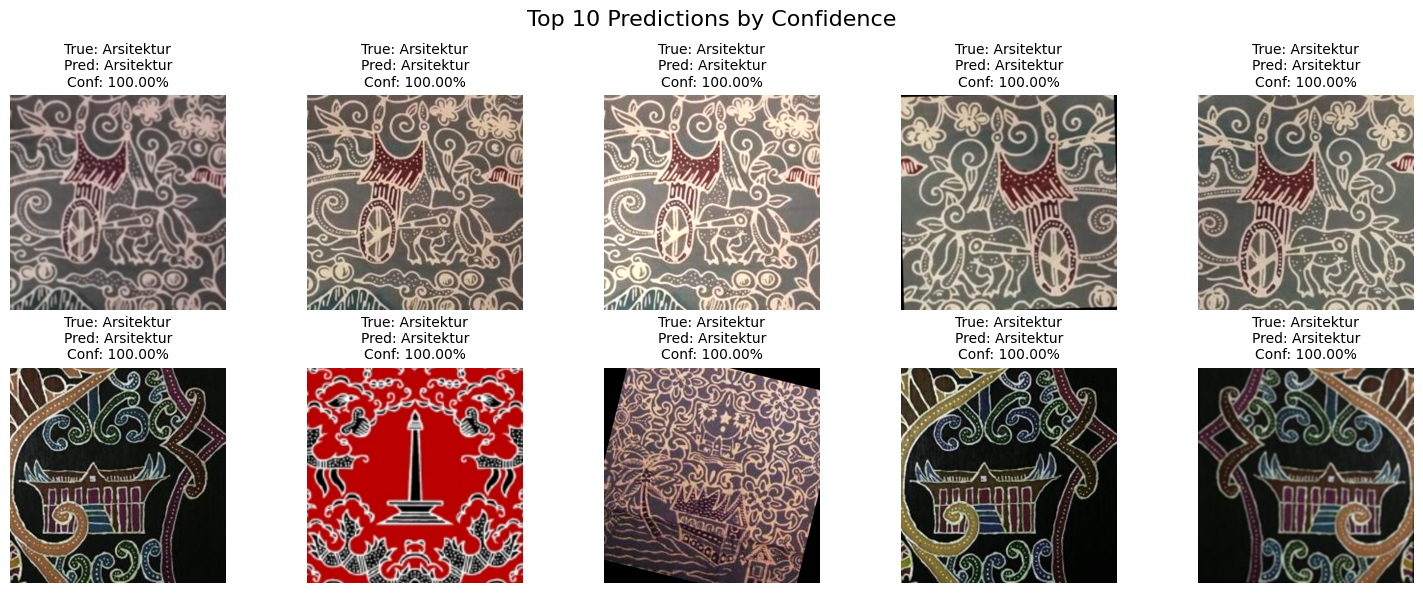

In [ ]:
predictions = model.predict(test_gen)
class_labels = list(test_gen.class_indices.keys())
true_indices = test_gen.classes
predicted_indices = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Visualization function
def visualize_predictions(indices, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_path = test_gen.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_labels[true_indices[idx]]
        predicted_label = class_labels[predicted_indices[idx]]
        confidence = prediction_confidences[idx] * 100

        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lowest and highest confidence predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]
high_conf_indices = np.argsort(prediction_confidences)[-10:][::-1]

visualize_predictions(low_conf_indices, "Lowest 10 Predictions by Confidence")
visualize_predictions(high_conf_indices, "Top 10 Predictions by Confidence")

## **Evaluasi**

In [ ]:
def evaluate_by_folder(generator, predictions):
    folder_results = defaultdict(lambda: {"correct": 0, "total": 0})
    predicted_indices = np.argmax(predictions, axis=1)

    for filepath, true_idx, pred_idx in zip(generator.filepaths, generator.classes, predicted_indices):
        folder = os.path.basename(os.path.dirname(filepath))
        folder_results[folder]["total"] += 1
        if true_idx == pred_idx:
            folder_results[folder]["correct"] += 1

    return {folder: f"{result['correct']}/{result['total']}" for folder, result in folder_results.items()}

folder_results = evaluate_by_folder(test_gen, predictions)
print("Folder-wise Evaluation Results:")
for folder, result in folder_results.items():
    print(f"{folder}: {result}")

Folder-wise Evaluation Results:
Arsitektur: 164/186
Budaya: 130/203
Fauna: 152/198
Flora: 139/200


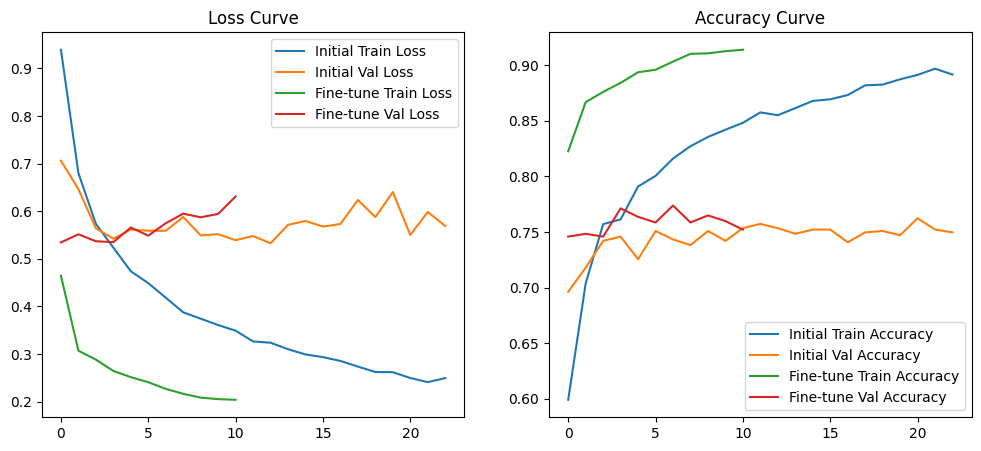

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Initial Train Loss")
plt.plot(history.history["val_loss"], label="Initial Val Loss")
plt.plot(history_fine_tune.history["loss"], label="Fine-tune Train Loss")
plt.plot(history_fine_tune.history["val_loss"], label="Fine-tune Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Initial Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Val Accuracy")
plt.plot(history_fine_tune.history["accuracy"], label="Fine-tune Train Accuracy")
plt.plot(history_fine_tune.history["val_accuracy"], label="Fine-tune Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

In [ ]:
pip freeze > requirements.txt